## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

### Ce modèle est spécifique aux données de la scène 3D avec un angle de caméra fixe 

In [180]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [181]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [225]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 50, 50

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.jpg") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".jpg"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.uint8)

            images_info.append({
                "tl": int(tl),
                "pl": int(pl),
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=160, px=-0.3892334257113643, py=0.14166938114040184


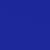

In [226]:
images_info[2]['image']

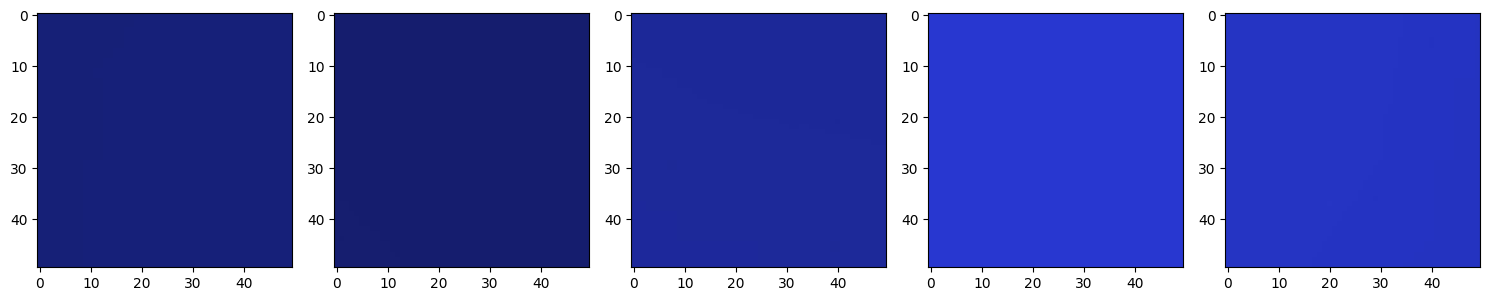

In [227]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [228]:
images_info.sort(key=lambda d: (d["tl"], d["pl"]))

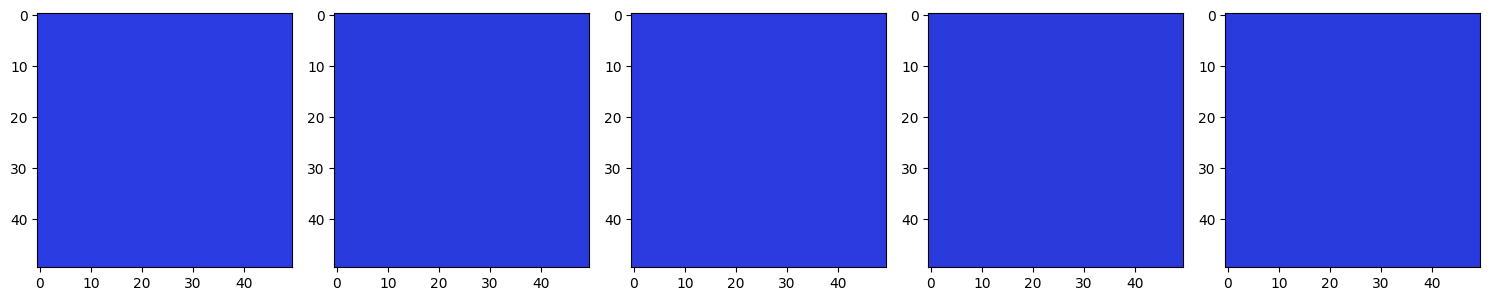

In [229]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# Cette fois ci visualisation de l'oraganisation des texels en fonctin des positions stéréo

In [230]:
# On prend le pixel le plus au centre
texel_row = img_height // 2
texel_col = img_width // 2
texel_position_str = f"({texel_row}, {texel_col})" # Pour l'affichage
print(texel_position_str)

(25, 25)


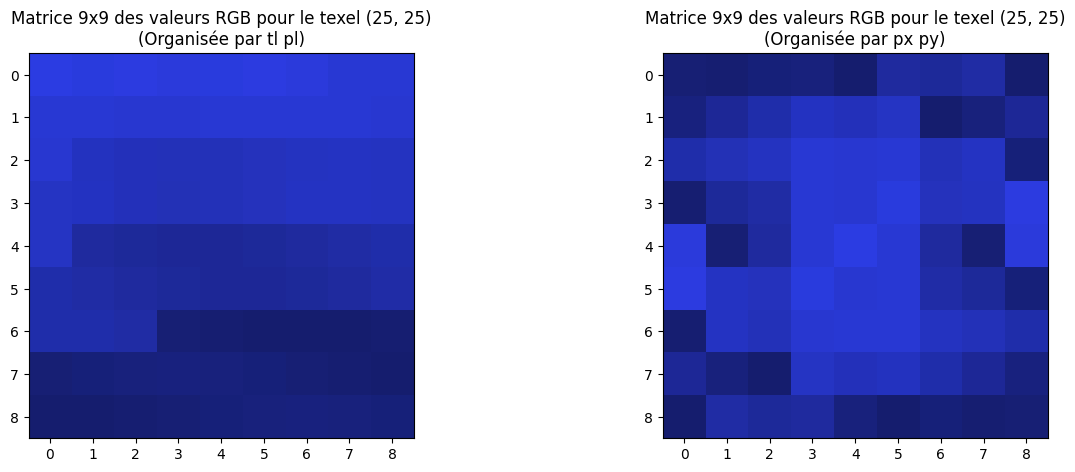

In [231]:
# Visualiser l'organisation de la matrice 9*9 en fonction du tri
# D'abord tl pl puis px, py
texel_angles = []
texel_stereo = []

images_angles = copy.deepcopy(images_info) # Copie pour le tri par angles
images_stereo = copy.deepcopy(images_info) # Copie pour le tri par stéréographiques


# Appliquer les tris aux copies distinctes
images_angles.sort(key=lambda d: (d["tl"], d["pl"]))
images_stereo.sort(key=lambda d: (d["px"], d["py"]))


for ang, ste in zip(images_angles, images_stereo):
    # info["pixels"] est le tableau NumPy 30x30x3 pour l'image entière de cette configuration angulaire
    texel_rgb_a = ang["pixels"][texel_row, texel_col, :]
    texel_rgb_s = ste["pixels"][texel_row, texel_col, :]
    texel_angles.append(texel_rgb_a)
    texel_stereo.append(texel_rgb_s)

# Convertir la liste en tableau NumPy
texel_angles_np = np.array(texel_angles, dtype=np.uint8) # Forme (81, 3)
texel_stereo_np = np.array(texel_stereo, dtype=np.uint8) # Forme (81, 3)

# Remodeler en matrice 9x9x3
mat_a = texel_angles_np.reshape((9, 9, 3))
mat_s = texel_stereo_np.reshape((9, 9, 3))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_a)
axes[1].imshow(mat_s)
axes[0].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par tl pl)")
axes[1].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par px py)")
plt.show()


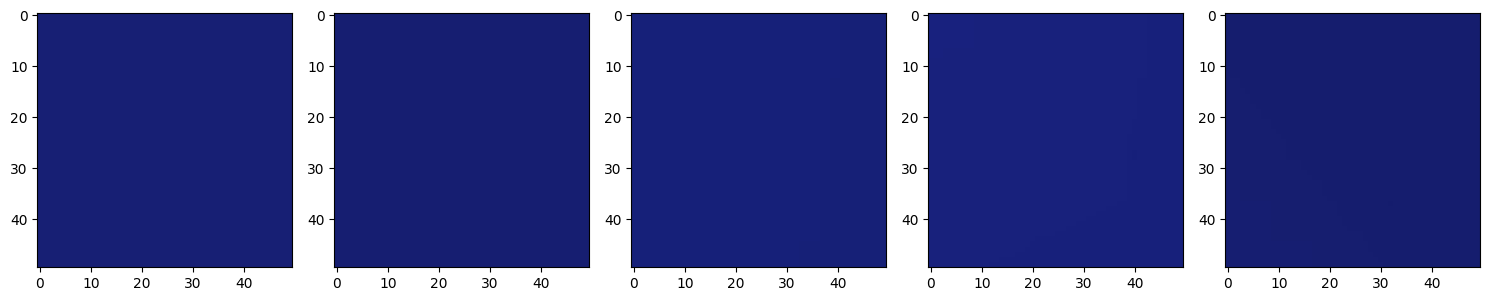

In [232]:
# Comme trier par les coordonnées stéréo sembl  plus adapté ici, c'est ce qu'on va choisir
images_info.sort(key=lambda d: (d["px"], d["py"]))
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

In [233]:
images_info[0]['pixels'][0, 0]

array([ 23,  31, 116], dtype=uint8)

In [234]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [ 22  32 121]
Nombre d'images importées: 81


# Création du modèles

In [235]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Bloc 2
x = Conv2D(filters = 128, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light = Model(inputs=i, outputs=latent_output, name="EncoderLight")
encoder_model_light.summary()

Model: "EncoderLight"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 9, 9, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 9, 9, 64)       │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 9, 9, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_output (Dense)           │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,520 (314.53 KB)

 Trainable params: 80,136 (313.03 KB)

 Non-trainable params: 384 (1.50 KB)

In [236]:
# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input = Input(shape=(input_dim,), name='decoder_input')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input)

x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model = Model(inputs=decoder_input, outputs=decoder_output, name="Decoder")
decoder_model.summary()

Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 106)            │         1,166 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 106)            │        11,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rgb_output (Dense)              │ (None, 3)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,513 (138.72 KB)

 Trainable params: 35,513 (138.72 KB)

 Non-trainable params: 0 (0.00 B)

In [237]:
# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light(i)
decoder_input = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model(decoder_input)

vae = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE')
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight        │ (None, 8)         │     80,520 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 10)        │          0 │ EncoderLight[0][… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (None, 3)         │     35,513 │ concatenate_8[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 115,649 (451.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [238]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
Sur un seul texel pour commencer

In [239]:
# on prend toutes les images
image_stack = np.stack([info["pixels"] for info in images_info], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [240]:
# on fait de même avec les angles
tl_stack = np.stack([info["tl"] for info in images_info], axis=0)
pl_stack = np.stack([info["pl"] for info in images_info], axis=0)

# et pour les positions stéréo
px_stack = np.stack([info["px"] for info in images_info], axis=0)
py_stack = np.stack([info["py"] for info in images_info], axis=0)

In [241]:
# Préparation des données

# Choisir UN texel
texel_position = (0, 0)
texel_observations = image_stack[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations[:len(texel_observations)] = texel_observations

input_train_batch_2d = padded_observations.reshape((1, matrix_H, matrix_W, num_channels))
target_rgb_train = texel_observations  # (81, 3)
light_dirs = np.stack([px_stack, py_stack], axis=1) # Forme (81, 2)

In [242]:
custom_optimizer = Adam(learning_rate=0.2) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae.compile(custom_optimizer, loss=lambda y_true, y_pred: 0.5 * custom_reconstruction_loss(y_true, y_pred))

history_vae = vae.fit([np.repeat(input_train_batch_2d, samples, axis=0), light_dirs], target_rgb_train,
        epochs=400, batch_size=5, validation_split=0.2)

Epoch 1/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 76678504.0000 - val_loss: 1498513920.0000
Epoch 2/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3626539.5000 - val_loss: 70488840.0000
Epoch 3/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28686918.0000 - val_loss: 1693287.5000
Epoch 4/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8345455.5000 - val_loss: 328417952.0000
Epoch 5/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 417499.3438 - val_loss: 18395.5684
Epoch 6/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2790.3596 - val_loss: 1416.4062
Epoch 7/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1930.2389 - val_loss: 964.3853
Epoch 8/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2179.5879 - val_loss: 954.5302
Epoch 9/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2007.8091 - val_loss: 956.5103
Epoch 10/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1566.8615 - val_loss: 1004.7182
Epoch 11/400
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

dict_keys(['loss', 'val_loss'])


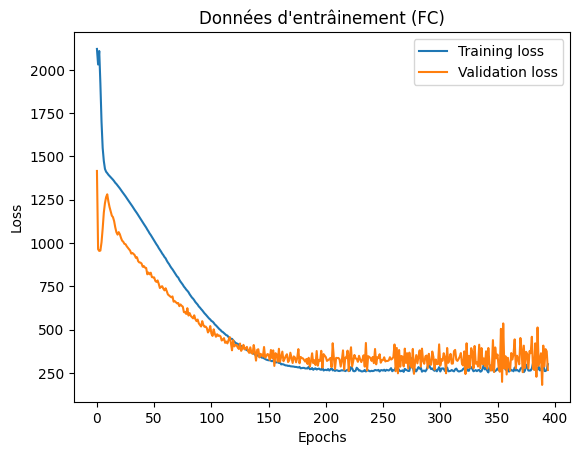

In [243]:
# Evaluer l'apprentissage d'un modèle --Code: Patrick Reuter--
def montrerCourbesApprentissage(history):
    #list all data in history
    print(history.history.keys())

    plt.plot(history.history['loss'][5:], label="Training loss")
    plt.plot(history.history['val_loss'][5:], label="Validation loss")

    plt.title("Données d'entrâinement (FC)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

montrerCourbesApprentissage(history_vae)

# Prédicitions d'un texel avec une configuration spécifique

In [284]:
index = 3
light_direction =light_dirs[index]

latent_vector = encoder_model_light.predict(input_train_batch_2d)[0]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted RGB: [[ 31.513569  43.50261  166.81163 ]] Original [ 24  33 126]


# Prédiction avec carte des vecteurs latents

In [244]:
# Générer carte latente composée de tous les vecteurs latent par texel
latent_map = np.zeros((img_height, img_width, latent_dim), dtype=np.float32)

for y in range(img_height):
    for x in range(img_width):
        texel_rgb_values_all_configs = image_stack[:, y, x, :] # (num_angles, 3)
        input_encoder_for_texel = texel_rgb_values_all_configs.reshape((matrix_H, matrix_W, num_channels)) # (9, 9, 3)
        
        # Ajouter une dimension de batch (batch_size=1)
        input_encoder_for_texel_batch = np.expand_dims(input_encoder_for_texel, axis=0) # (1, 9, 9, 3)

        # Prédire le vecteur latent
        latent_vector = encoder_model_light.predict(input_encoder_for_texel_batch, verbose=0)[0] # (8,)
        latent_map[y, x] = latent_vector

print(f"Forme de la carte latente: {latent_map.shape}")

Forme de la carte latente: (50, 50, 8)


In [279]:
def predict_image_from_latent(latent_map, light_direction_2d):
    """
    latent_map: (H, W, 8) carte des vecteurs latents
    light_direction_2d: (2,) stéréographique [lx, ly] (pour la lumière)
    """
    H, W, latent_dim = latent_map.shape
    
    # Le décodeur attend latent_dim + 2 dimensions
    decoder_input_dim_expected = latent_dim + 2 # Ici, 8 + 2 = 10

    # Flatten latent map
    latent_flat = latent_map.reshape(-1, latent_dim)  # (H*W, 8)

    # Répéter la direction de lumière pour tous les texels
    # Assurez-vous que light_direction_2d est bien de forme (2,)
    dir_repeated = np.repeat(light_direction_2d[np.newaxis, :], H * W, axis=0)  # (H*W, 2)

    # Concaténer
    decoder_input = np.concatenate([latent_flat, dir_repeated], axis=1)  # (H*W, 10)

    # Vérification (optionnel mais utile pour le debug)
    if decoder_input.shape[1] != decoder_input_dim_expected:
        raise ValueError(f"La dimension d'entrée du décodeur ne correspond pas. Attendu: {decoder_input_dim_expected}, Trouvé: {decoder_input.shape[1]}")

    # Prédiction
    predicted_rgb_flat = decoder_model.predict(decoder_input, verbose=0)  # (H*W, 3)
    predicted_image = predicted_rgb_flat.reshape(H, W, 3).astype(np.uint8) # Convertir en uint8
    return predicted_image

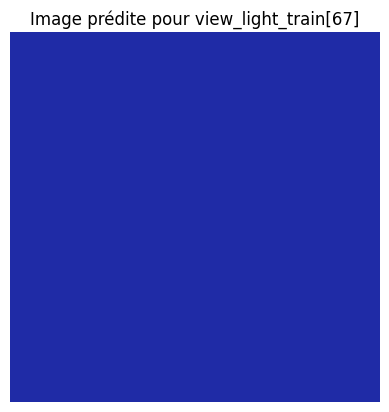

In [280]:
# Choix d'une image à prédire
index = 67

direction = light_dirs[index]  # (2,)
predicted_image = predict_image_from_latent(latent_map, direction)

plt.imshow(predicted_image)
plt.title(f"Image prédite pour view_light_train[{index}]")
plt.axis('off')
plt.show()

In [281]:
def show_comparison(predicted_image, ground_truth_image):
    # Différence absolue par pixel
    diff_image = np.abs(predicted_image.astype(np.int16) - ground_truth_image.astype(np.int16))

    # Affichage
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(predicted_image)
    axs[0].set_title("Image prédite")
    axs[0].axis('off')

    axs[1].imshow(ground_truth_image)
    axs[1].set_title("Image réelle")
    axs[1].axis('off')

    axs[2].imshow(diff_image)
    axs[2].set_title("Différence absolue")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

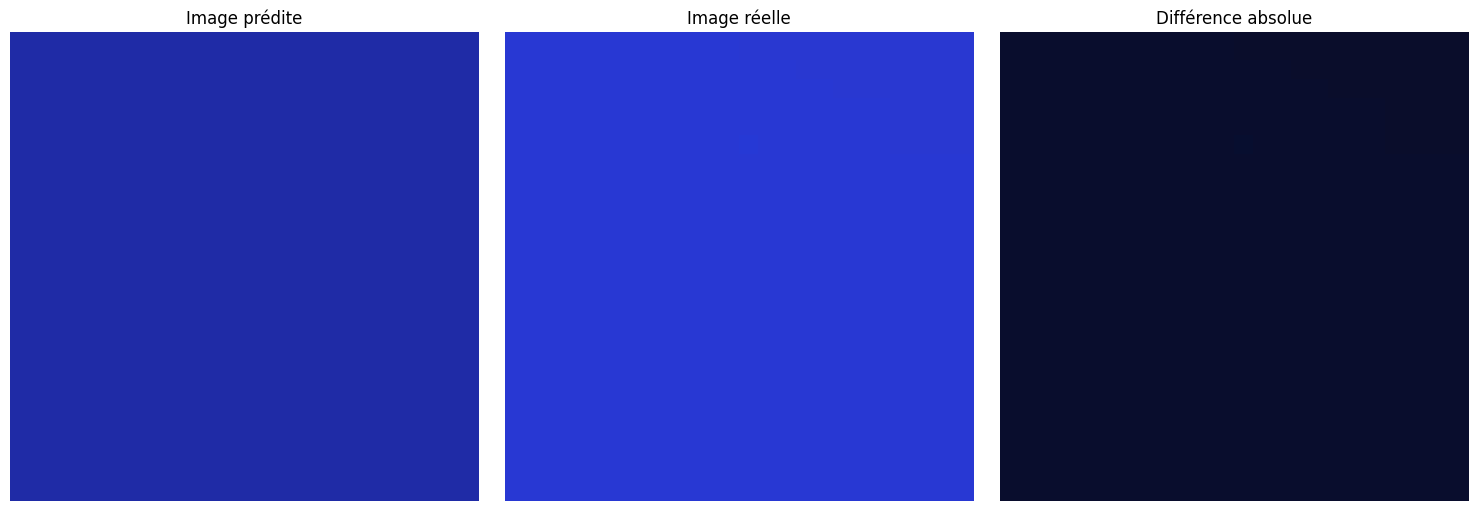

In [282]:
# Afficher la comparaison entre les images
index = 30
direction = light_dirs[index]
predicted_image = predict_image_from_latent(latent_map, direction)
ground_truth_image = image_stack[index]  # (H, W, 3)

show_comparison(predicted_image, ground_truth_image)

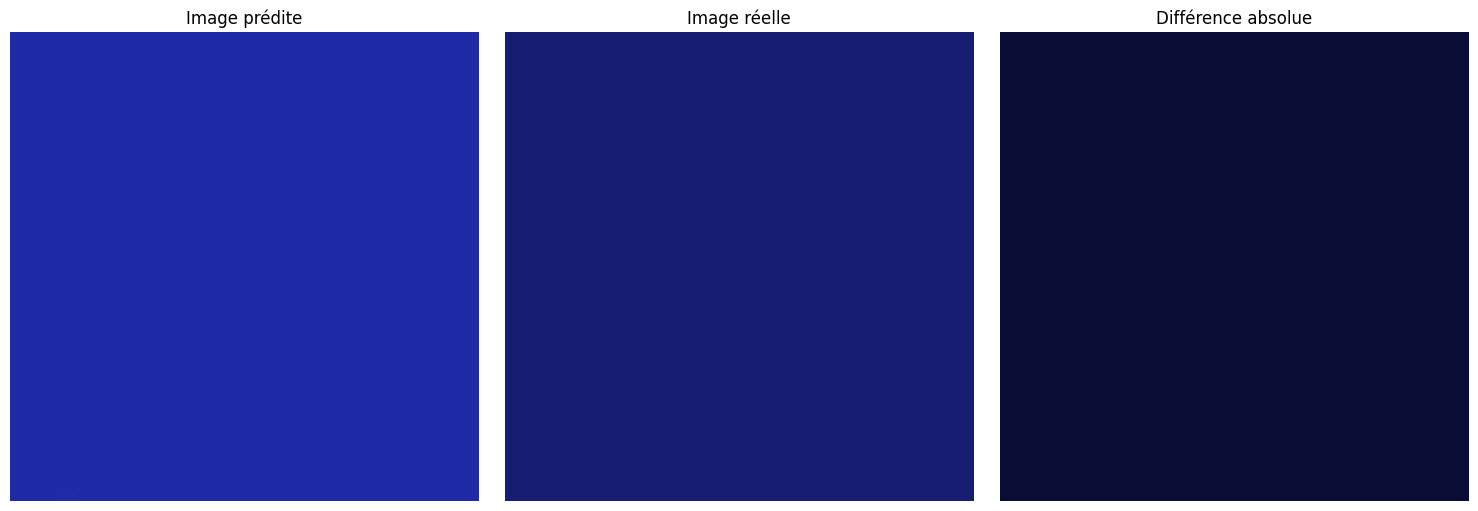

In [269]:

# Afficher la comparaison entre les images
index = 1
direction = light_dirs[index]
predicted_image = predict_image_from_latent(latent_map, direction)
ground_truth_image = image_stack[index]  # (H, W, 3)

show_comparison(predicted_image, ground_truth_image)